In [17]:
from pathlib import Path
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Rename files that don't match new naming scheme


# Actual analysis


## Data loading


In [8]:
def extract_exp_name(filename, str_pre, str_post, sep="_"):
    start_idx = filename.find(str_pre) + len(str_pre)
    end_idx = filename.find(str_post)
    return filename[start_idx:end_idx].strip(sep)
    

#### Find files

In [9]:
# Find all matching files
str_pre = "25-05-09-1508_Rothamsted_porg00475"
str_post = "npk_res_ini"
search_pattern = f"*{str_pre}*{str_post}*"
matches = Path("results/full_spinup").glob(search_pattern)
sorted_fn = sorted([str(m) for m in matches])

experiment_filepaths = {}
for fn in sorted_fn:
    exp_name = extract_exp_name(fn, str_pre, str_post)
    experiment_filepaths[exp_name] = fn

#### Load data


In [10]:
relevant_fields = {"RB_L", "NPP_L", "P", "Date", "Datam", "Zbio", "rsd", "Bio_Zs"}
data = {}
for exp, fn in experiment_filepaths.items():
    data[exp] = {
        k.rstrip("_L"): np.asarray(v)
        for k, v in loadmat(fn).items() if k in relevant_fields        
    }

In [57]:
for exp in data.values():
    # Year for each day of the simulation (Datam is in h, hence only every 24th)
    exp["years_daily"] = exp["Datam"][::24,0]
    exp["years"] = np.unique(exp["years_daily"])[1:]  # Skip first year as no harvest yet
    exp["years_dt"] = np.arange(str(exp["years"][0]), str(exp["years"][-1]+1), dtype="datetime64[Y]")
    exp["days_dt"] = np.arange(str(exp["years"][0]) + "-01-01", str(exp["years"][-1]+1) + "-01-01", dtype="datetime64[D]")

## Yield

In [58]:
def get_predicted_yields(data, only_pos_values=True):
    for exp_data in data.values():
        yield_yearly_pred = np.zeros((len(exp_data["years"]), exp_data["RB"].shape[1], 7))
        for i, yr in enumerate(exp_data["years"]):
            RB_curr_yr = exp_data["RB"][1:][exp_data["years_daily"]==yr]
            if only_pos_values:
                # Set negative yields (mostly at planting) to 0
                RB_curr_yr[RB_curr_yr < 0] = 0
            yield_yearly_pred[i] = RB_curr_yr.sum(0)
        # Grains are fruit (4) and C reserve (3) compartments
        exp_data["grain_yield"] = yield_yearly_pred[:, :, [3, 4]].sum(2).squeeze(-1)
        # Straw is leaves (0), sapwood (1), and dead leaves (6) compartments
        exp_data["straw_yield"] = yield_yearly_pred[:, :, [0, 1, 6]].sum(2).squeeze(-1)

In [59]:
get_predicted_yields(data)

In [67]:
# Get observed yields
obs_path = "data/Rothamsted_yield_data.csv"
relevant_section = 1

obs_data = pd.read_csv(obs_path)
obs_data = obs_data[obs_data.section == relevant_section]

# From t/ha to gC/m2
obs_dry_matter_content = 0.8
obs_c_content = 0.45
yield_conversion_factor = obs_dry_matter_content * obs_c_content * 1e2

for exp_name, exp_data in data.items():
    strip = int(exp_name.split("_")[0])
    relevant_data = obs_data[
        (obs_data.strip == strip)
        & np.isin(obs_data.harvest_year, exp_data["years"])
    ]
    assert (exp_data["years"] == relevant_data.harvest_year.values).all()
    relevant_data.loc[relevant_data.grain=="*", "grain"] = float("nan")
    relevant_data.loc[relevant_data.straw=="*", "straw"] = float("nan")
    exp_data["grain_yield_obs"] = (relevant_data.grain.astype(float).values * yield_conversion_factor)
    exp_data["straw_yield_obs"] = (relevant_data.straw.astype(float).values * yield_conversion_factor)

Unshifted correlation coefficient: 0.1613
Correlation coefficient when moving predictions ahead in time by...
... 1 timestep: 0.2877
... 2 timesteps: 0.0700
... 3 timesteps: -0.2254
... 4 timesteps: 0.1086
Correlation coefficient when moving predictions back in time by...
... 1 timestep: -0.0914
... 2 timesteps: -0.1948
... 3 timesteps: -0.2417
... 4 timesteps: 0.0991


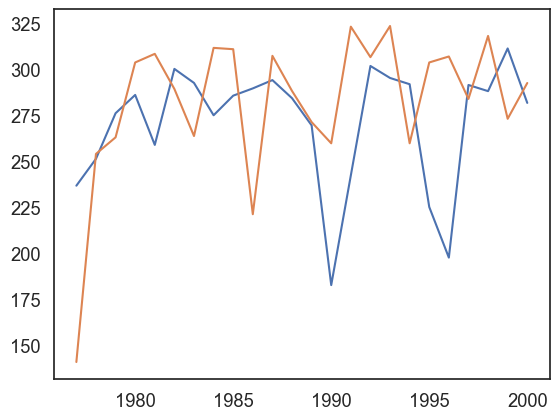

In [133]:
exp = "21_FymN2"
plt.plot(data[exp]["years"], data[exp]["grain_yield"])
plt.plot(data[exp]["years"], data[exp]["grain_yield_obs"])

corr_0 = np.corrcoef(data[exp]["grain_yield"], data[exp]["grain_yield_obs"])[0,1]
print(f"Unshifted correlation coefficient: {corr_0:.4f}")

print("Correlation coefficient when moving predictions ahead in time by...")
for shift in range(1, 5):
    pred = data[exp]["grain_yield"][shift:]
    obs = data[exp]["grain_yield_obs"][:-shift]
    corr = np.corrcoef(pred, obs)[0,1]
    print(f"... {shift} timestep{'' if shift==1 else 's'}: {corr:.4f}")
print("Correlation coefficient when moving predictions back in time by...")
for shift in range(1, 5):
    pred = data[exp]["grain_yield"][:-shift]
    obs = data[exp]["grain_yield_obs"][shift:]
    corr = np.corrcoef(pred, obs)[0,1]
    print(f"... {shift} timestep{'' if shift==1 else 's'}: {corr:.4f}")

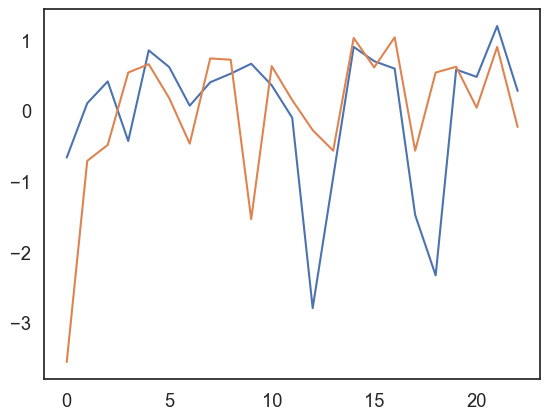

In [130]:
plt.plot(normalize(data[exp]["grain_yield"][1:]))
plt.plot(normalize(data[exp]["grain_yield_obs"][:-1]))

In [68]:
for exp in data.values():
    for yield_type in ("grain", "straw"):
        for suffix in ["", "_obs"]:
            varname = f"{yield_type}_yield{suffix}"
            val = exp[varname]
            mean = np.mean(val)
            std = np.std(val)
            exp[f"mean_{varname}"] = mean
            exp[f"std_{varname}"] = std
            exp[f"normalized_{varname}"] = (val - mean) / std

In [39]:
sns.set(font_scale=1.2)
sns.set_style("white")

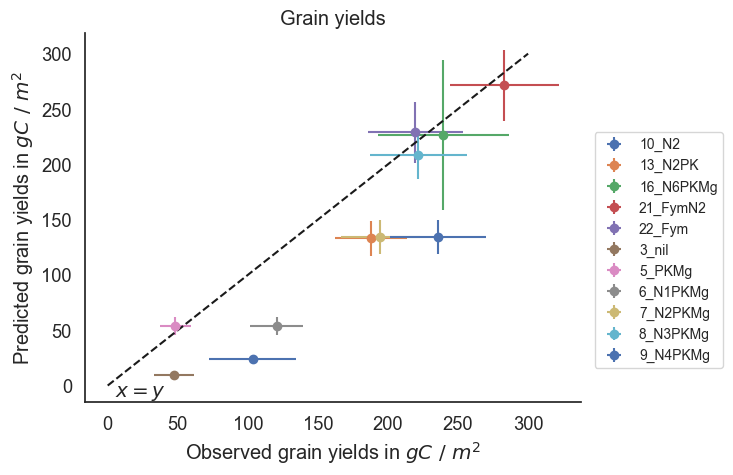

In [190]:
for k, exp in sorted(data.items()):
    x = [exp["mean_grain_yield_obs"]]
    y = [exp["mean_grain_yield"]]
    xerr = [exp["std_grain_yield_obs"]]
    yerr = [exp["std_grain_yield"]]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,300], [0,300], "k--")
plt.annotate("$x = y$", (5, -10))
plt.xlabel(r"Observed grain yields in $gC \ / \ m^2$")
plt.ylabel(r"Predicted grain yields in $gC \ / \ m^2$")
plt.title("Grain yields")
plt.legend(fontsize="x-small", bbox_to_anchor=(1.3, 0.75))
# plt.legend(loc="best", fontsize="x-small"
sns.despine()
plt.savefig("grain_yields.png")
plt.savefig("grain_yields.svg")

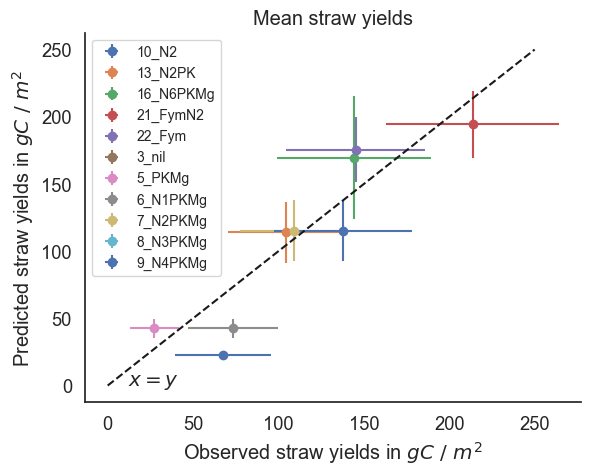

In [183]:
for k, exp in sorted(data.items()):
    x = [exp["mean_straw_yield_obs"]]
    y = [exp["mean_straw_yield"]]
    xerr = [exp["std_straw_yield_obs"]]
    yerr = [exp["std_straw_yield"]]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,250], [0,250], "k--")
plt.annotate("$x = y$", (12, 0))
plt.xlabel(r"Observed straw yields in $gC \ / \ m^2$")
plt.ylabel(r"Predicted straw yields in $gC \ / \ m^2$")
plt.title("Mean straw yields")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("straw_yields.svg")
plt.savefig("straw_yields.png")

#### Pearson correlation coefficient

In [169]:
annual_grain_yield_means = np.mean(np.vstack([exp["normalized_grain_yield"] for exp in data.values()]), 0)
annual_grain_yield_means_obs = np.mean(np.vstack([exp["normalized_grain_yield_obs"] for exp in data.values()]), 0)

In [156]:
corr = np.corrcoef(annual_grain_yield_means, annual_grain_yield_means_obs)[0,1]
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: 0.1774


##### Significance of correlation

In [159]:
count=0
N = 10000
for i in range(N):
    perm = np.random.permutation(annual_grain_yield_means_obs)
    if np.corrcoef(annual_grain_yield_means, perm)[0,1] > corr:
        count += 1
print(f"p-value of the correlation coefficient (one-sided): {count / N:.3f}")

p-value of the correlation coefficient (one-sided): 0.209


In [164]:
all_gym = np.hstack([exp["normalized_grain_yield"][1:] for exp in data.values()])
all_gym_o = np.hstack([exp["normalized_grain_yield_obs"][:-1] for exp in data.values()])
corr_all = np.corrcoef(all_gym, all_gym_o)[0,1]

In [164]:
all_gym = np.hstack([exp["normalized_grain_yield"][1:] for exp in data.values()])
all_gym_o = np.hstack([exp["normalized_grain_yield_obs"][:-1] for exp in data.values()])
corr_all = np.corrcoef(all_gym, all_gym_o)[0,1]

In [165]:
count=0
N = 10000
for i in range(N):
    perm = np.random.permutation(all_gym_o)
    if np.corrcoef(all_gym, perm)[0,1] > corr_all:
        count += 1
print(f"p-value of the correlation coefficient (one-sided): {count / N:.3f}")

p-value of the correlation coefficient (one-sided): 0.059


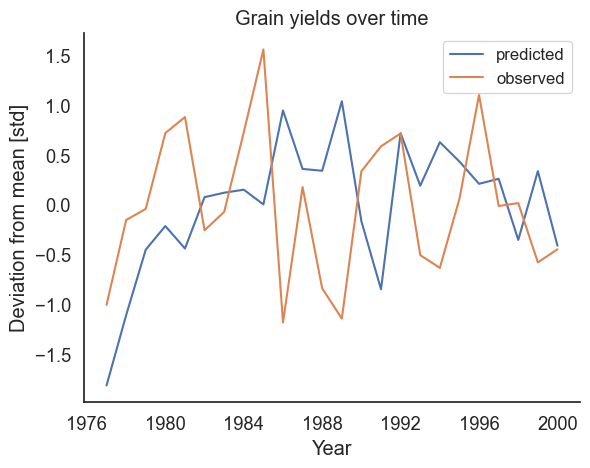

In [179]:
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_means, label="predicted")
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_means_obs, label="observed")
plt.xlabel("Year")
plt.ylabel("Deviation from mean [std]")
plt.title("Grain yields over time")
plt.legend(loc="best", fontsize="small")
sns.despine()
plt.savefig("grain_yields_annual.svg")
plt.savefig("grain_yields_annual.png")

In [146]:
window_size = 5
ag5 = np.lib.stride_tricks.sliding_window_view(
    annual_grain_yield_means, window_shape=5).mean(1)
ag5_obs = np.lib.stride_tricks.sliding_window_view(
    annual_grain_yield_means_obs, window_shape=5).mean(1)

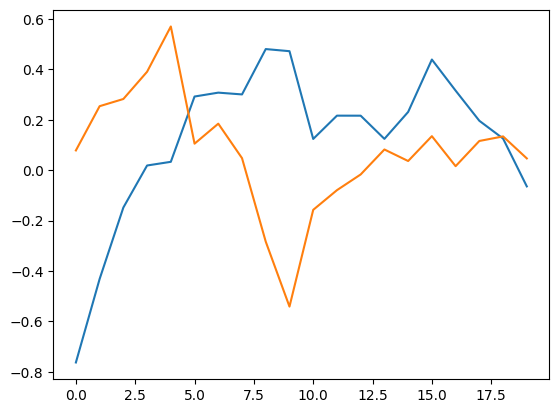

In [147]:
plt.plot(ag5)
plt.plot(ag5_obs)

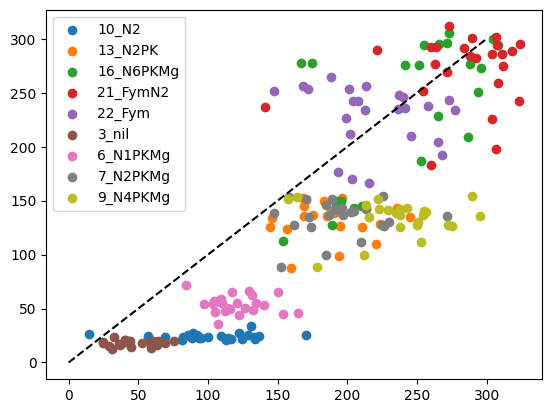

In [153]:
for name, exp in data.items():
    plt.scatter(exp["grain_yield_obs"], exp["grain_yield"], label=name)
plt.plot([0,300], [0,300], "k--")
plt.legend(loc="best")    

In [174]:
for name, exp in data.items():
    print(name)
    print(np.corrcoef(exp["grain_yield_obs"][:-1], exp["grain_yield"][1:])[0,1])
    print()

10_N2
-0.10989492297947132

13_N2PK
-0.040154171532478716

16_N6PKMg
0.7120081992272467

21_FymN2
0.28770310756979606

22_Fym
0.021859287558176753

3_nil
0.17321075549670417

5_PKMg
-0.4624844737786963

6_N1PKMg
-0.19784346114218318

7_N2PKMg
0.14932936587380463

8_N3PKMg
0.34123633131955905

9_N4PKMg
0.13031767991732357



In [177]:
corr_coeffs = [np.corrcoef(exp["grain_yield_obs"][:], exp["grain_yield"][:])[0,1] for exp in data.values()]

In [178]:
np.mean(corr_coeffs)

np.float64(0.028950288561386886)

## Soil SOC and N

In [84]:
soc = {
    "years": np.fromiter((str(yr) for yr in [1966, 1987, 1992, 1997, 2000]), dtype="datetime64[Y]"),
    "3_nil": [0.87, 0.9, 0.77, 0.75, 0.85],
    "5_PKMg": [0.94, 0.91, 0.94, 0.82, 0.91],
    "8_N3PKMg": [1.08, 1.12, 1.07, 1.03, 1.15],
    "22_Fym": [2.61, 2.82, 2.68, 2.93, 2.89],
    "21_FymN2": [2.28, 2.34, 2.67, 2.62, 2.75],
}

soil_N = {
    "years": np.fromiter((str(yr) for yr in [1966, 1987, 1992, 1997, 2000]), dtype="datetime64[Y]"),
    "3_nil": [0.103, 0.102, 0.091, 0.09, 0.088],
    "5_PKMg": [0.109, 0.104, 0.101, 0.098, 0.094],
    "8_N3PKMg": [0.121, 0.126, 0.118, 0.119, 0.113],
    "9_N4PKMg": [0.114, 0.122, 0.122, 0.124, 0.118],
    "22_Fym": [0.255, 0.27, 0.271, 0.304, 0.273],
    "21_FymN2": [0.217, 0.228, 0.271, 0.272, 0.26],
}

In [85]:
for name, exp in data.items():
    bg_soil_mass = exp["Zbio"].squeeze() * (exp["rsd"] @ exp["Bio_Zs"].squeeze())
    soil_n_total = exp["P"][1:, 25:33].sum(1)
    soc_total = exp["P"][1:, 6:21].sum(1)
    exp["soil_N_daily"] =  soil_n_total / bg_soil_mass
    exp["SOC_daily"] = soc_total / bg_soil_mass
    exp["SOC"] = np.fromiter(
        ((exp["SOC_daily"][exp["years_daily"]==yr]).mean() for yr in exp["years"]),
        dtype=float
    )
    exp["soil_N"] = np.fromiter(
        ((exp["soil_N_daily"][exp["years_daily"]==yr]).mean() for yr in exp["years"]),
        dtype=float
    )    
    if name in soc:
        exp["SOC_obs"] = np.array(soc[name]) * 0.01
    if name in soil_N:
        exp["soil_N_obs"] = np.array(soil_N[name]) * 0.01

In [86]:
def normalize(x):
    return (x-x.mean()) / x.std()

#### SOC


In [92]:
soc_expmts = [exp for exp in data.values() if "SOC_obs" in exp]
soc_expmts_dict = {k: exp for k, exp in data.items() if "SOC_obs" in exp}
years_dt = soc_expmts[0]["years_dt"]
assert all((exp["years_dt"] == years_dt).all() for exp in soc_expmts)


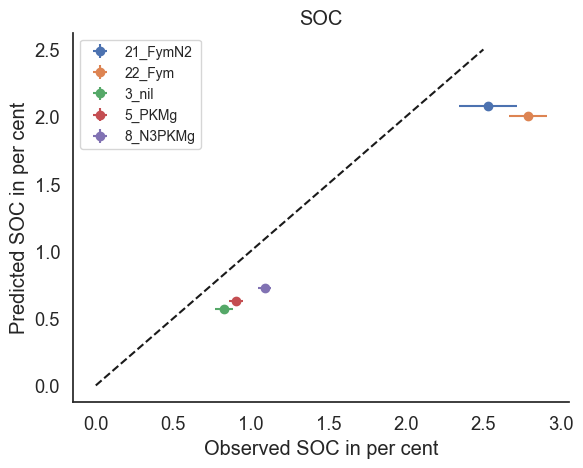

In [180]:
for k, exp in soc_expmts_dict.items():
    x = [np.mean(exp["SOC_obs"]) * 100]
    y = [np.mean(exp["SOC"]) * 100]
    xerr = [np.std(exp["SOC_obs"]) * 100]
    yerr = [np.std(exp["SOC"]) * 100]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,2.5], [0,2.5], "k--")
# plt.annotate("$x = y$", (12, 0))
plt.xlabel("Observed SOC in per cent")
plt.ylabel("Predicted SOC in per cent")
plt.title("SOC")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("soc.svg")
plt.savefig("soc.png")

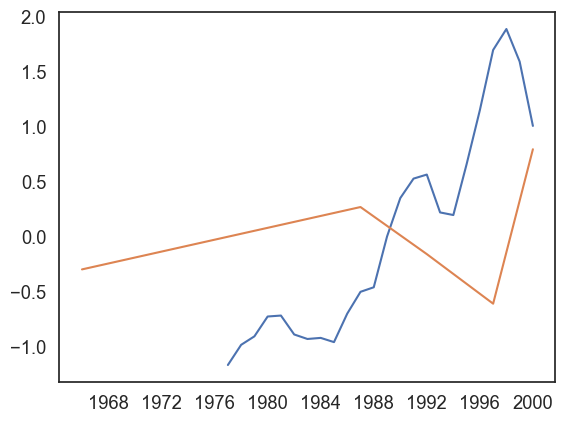

In [106]:
# Means over time
mean_soc = np.mean(np.vstack([exp["SOC"] for exp in soc_expmts]), 1)
mean_soc_obs = np.mean(np.vstack([exp["SOC_obs"] for exp in soc_expmts]), 1)

# Annual means of normalized values across experiments
mean_soc_annual = np.mean(np.vstack([normalize(exp["SOC"]) for exp in soc_expmts]), 0)
mean_soc_obs_annual = np.mean(np.vstack([normalize(exp["SOC_obs"]) for exp in soc_expmts]), 0)

plt.plot(years_dt, mean_soc_annual)
plt.plot(soc["years"], mean_soc_obs_annual)

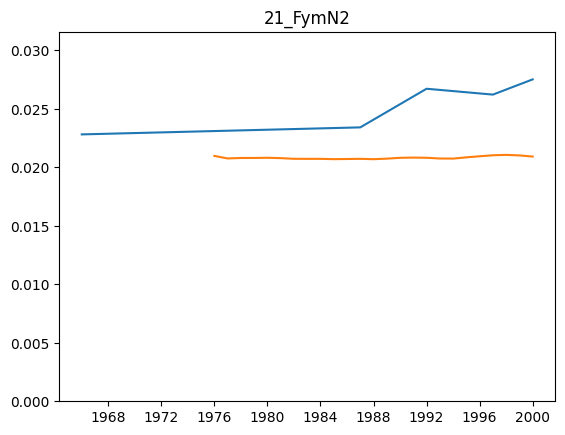

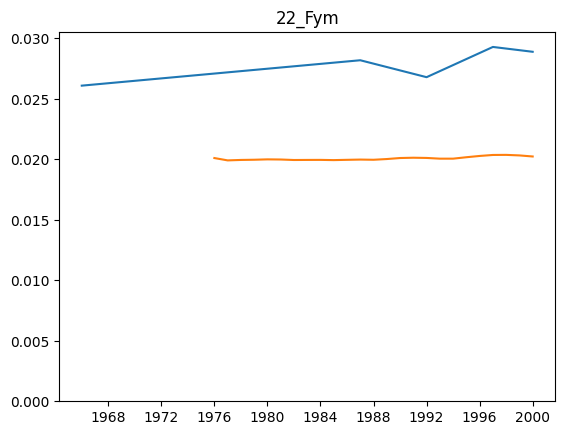

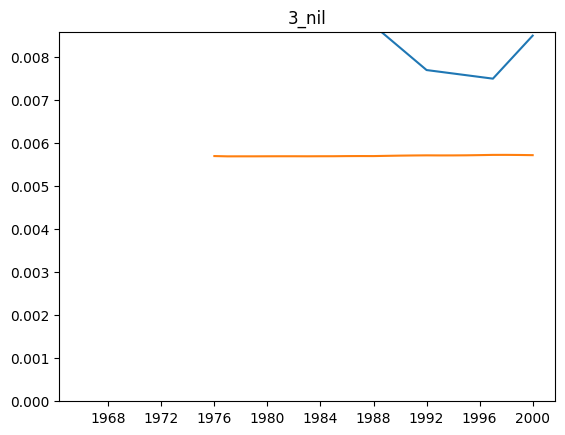

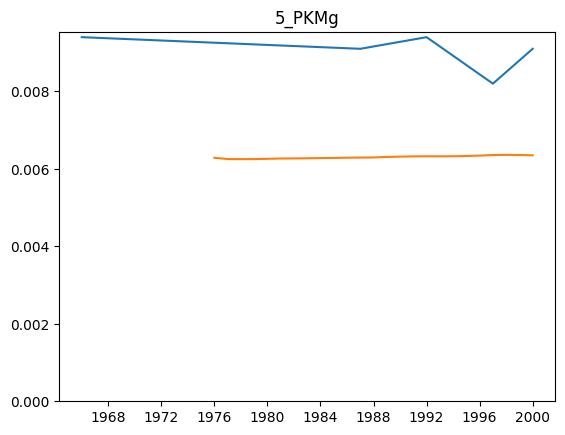

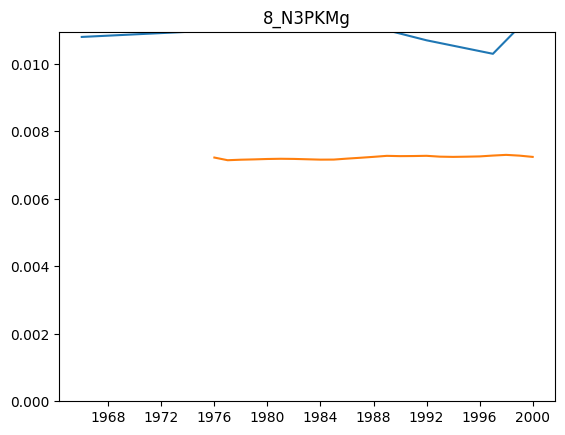

In [265]:
for name, exp in data.items():
    if not "SOC_obs" in exp:
        continue
    plt.figure()
    plt.title(name)
    plt.plot(soc["years"], exp["SOC_obs"])
    plt.plot(exp["years_dt"], exp["SOC"])
    plt.ylim(0, max(exp["SOC"]) * 1.5)

In [ ]:
plt.scatter(

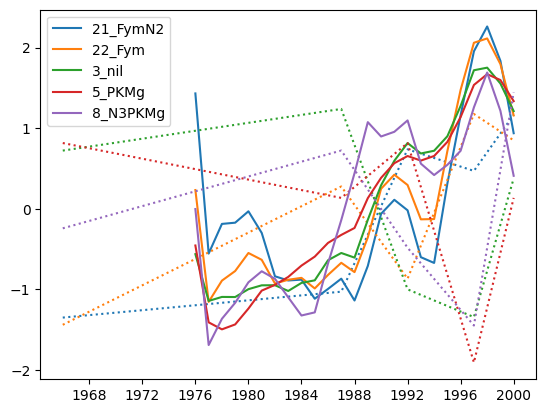

In [237]:
# exp = data["21_FymN2"]
fig, ax = plt.subplots()
for name, exp in data.items():
    if "SOC_obs" in exp:
        color = ax._get_lines.get_next_color()
        plt.plot(exp["years_dt"], normalize(exp["SOC"]), color=color, label=name)
        # plt.plot(exp["days_dt"], normalize(exp["SOC_daily"]))
        plt.plot(soc["years"], normalize(exp["SOC_obs"]), color=color, linestyle="dotted")
plt.legend(loc="best")

In [271]:
# Means over time
mean_soc = np.mean(np.vstack([exp["SOC"] for exp in soc_expmts]), 1)
mean_soc_obs = np.mean(np.vstack([exp["SOC_obs"] for exp in soc_expmts]), 1)

# Annual means of normalized values across experiments
mean_soc_annual = np.mean(np.vstack([normalize(exp["SOC"]) for exp in soc_expmts]), 0)
mean_soc_obs_annual = np.mean(np.vstack([normalize(exp["SOC_obs"]) for exp in soc_expmts]), 0)

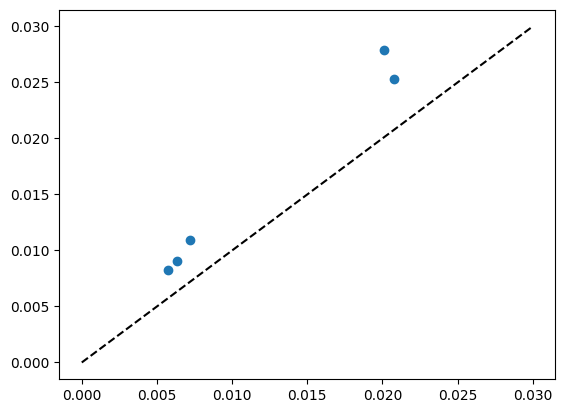

In [272]:
plt.scatter(mean_soc, mean_soc_obs)
plt.plot([0,0.03], [0, 0.03], "k--")

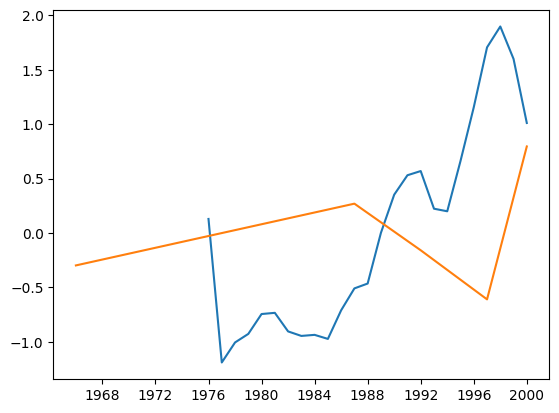

In [250]:
plt.plot(years_dt, mean_soc_annual)
plt.plot(soc["years"], mean_soc_obs_annual)

#### Soil N

In [98]:
soil_n_expmts = [exp for exp in data.values() if "soil_N_obs" in exp]
soil_n_expmts_dict = {k: exp for k, exp in data.items() if "soil_N_obs" in exp}
years_dt = soil_n_expmts[0]["years_dt"]
assert all((exp["years_dt"] == years_dt).all() for exp in soil_n_expmts)


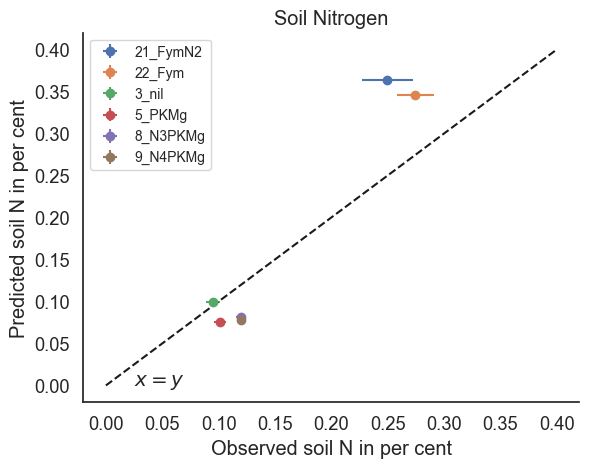

In [181]:
for k, exp in soil_n_expmts_dict.items():
    x = [np.mean(exp["soil_N_obs"]) * 100]
    y = [np.mean(exp["soil_N"]) * 100]
    xerr = [np.std(exp["soil_N_obs"]) * 100]
    yerr = [np.std(exp["soil_N"]) * 100]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,0.4], [0,0.4], "k--")
plt.annotate("$x = y$", (0.025, 0))
plt.xlabel("Observed soil N in per cent"
          )
plt.ylabel("Predicted soil N in per cent")
plt.title("Soil Nitrogen")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("soil_n.svg")
plt.savefig("soil_n.png")

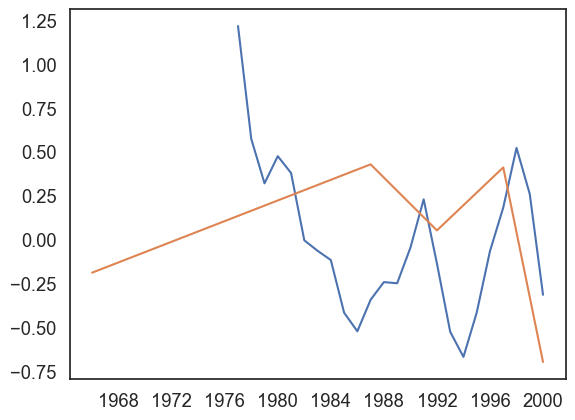

In [105]:
# Means over time
mean_soil_n = np.mean(np.vstack([exp["soil_N"] for exp in soil_n_expmts]), 1)
mean_soil_n_obs = np.mean(np.vstack([exp["soil_N_obs"] for exp in soil_n_expmts]), 1)

# Annual means of normalized values across experiments
mean_soil_n_annual = np.mean(np.vstack([normalize(exp["soil_N"]) for exp in soil_n_expmts]), 0)
mean_soil_n_obs_annual = np.mean(np.vstack([normalize(exp["soil_N_obs"]) for exp in soil_n_expmts]), 0)

plt.plot(years_dt, mean_soil_n_annual)
plt.plot(soil_N["years"], mean_soil_n_obs_annual)

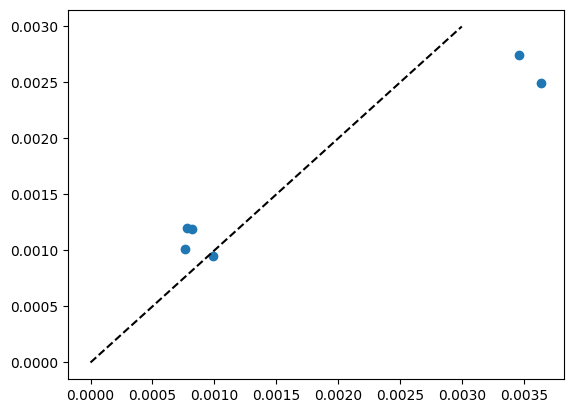

In [284]:
plt.scatter(mean_soil_n, mean_soil_n_obs)
plt.plot([0,0.003], [0, 0.003], "k--")

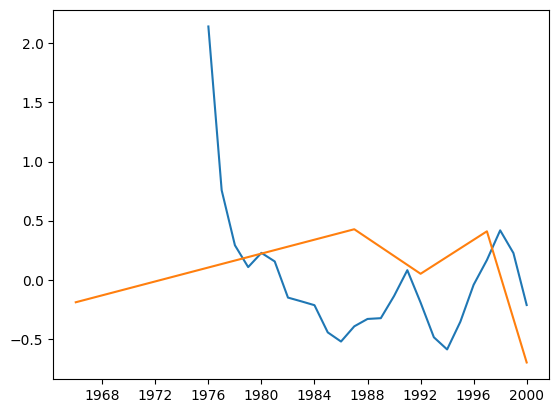

In [257]:
plt.plot(years_dt, mean_soil_n)
plt.plot(soil_n["years"], mean_soil_n_obs)